# Word recognition project using CNNs and spectrogram representation.
## School in AI project by Giacomo Sansone

The documentation of this project can be found on my github profile. Here is the link: https://github.com/pcineverdies/word-recognition. Since most of the ideas are expressed in the documentation, I won't repeat them in the code. Basically I will comment only what's new or difficult to understand. I suggest to read the documentation as I go on with the code. 

In [ ]:
!pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torchmetrics

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Torchaudio is a library for audio and signal processing with PyTorch. 
# It provides I/O, signal and data processing functions, datasets, 
# model implementations and application components.
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torchaudio.datasets import SPEECHCOMMANDS
import os

class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# We don't need the validation!
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

In [ ]:
new_sample_rate = 8000
sample_rate     = 16000

def transform(data):
  data = torchaudio.transforms.Resample(orig_freq=sample_rate, 
                                        new_freq=new_sample_rate)(data)
  return data


Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000
Label of the element: backward
Id of the speaker: 017c4098
Utterance number: 1



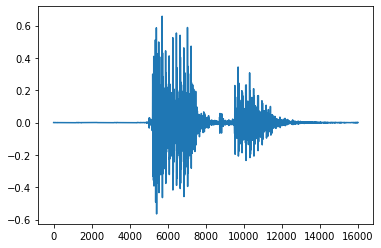

In [ ]:
# AN EXAMPLE OF THE DATA WE HAVE

waveform, sample_rate, label, speaker_id, utterance_number = train_set[2]
transformed = transform(waveform)

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))
print("Label of the element: {}".format(label))
print("Id of the speaker: {}".format(speaker_id))
print("Utterance number: {}\n".format(utterance_number))

plt.plot(waveform.t().numpy());
ipd.Audio(waveform.numpy(), 
          rate=sample_rate)

In [ ]:
labels = []
for elem in train_set:
  if elem[2] not in labels:
    labels.append(elem[2])
labels = sorted(labels)

def label_to_index(word):
    return torch.tensor(labels.index(word))

def index_to_label(index):
    return labels[index]

In [ ]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    res = []
    for item in batch:
      res.append(item.t())
    
    res = torch.nn.utils.rnn.pad_sequence(res, 
                                            batch_first=True, 
                                            padding_value=0)
    return res.permute(0, 2, 1)

"""
collate_fn:
  - input:  batch, array of elements form dataset
  - output: tensors, array of waveforms
            targets, array of labels for each waveform
  
This function is used to extract the key information from a batch of data
"""
def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        # Instead of the labels, we use the associated indexes
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 256

if device == "cuda":
    num_workers = 1
    # has to be true if you're training on NVIDIA gpu
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [ ]:
class M5(nn.Module):
    def __init__(self, n_input, n_output, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, 
                               n_channel,
                               kernel_size=80, 
                               stride=stride)
        
        self.bn1 = nn.BatchNorm1d(n_channel)

        self.pool1 = nn.MaxPool1d(4)

        self.conv2 = nn.Conv1d(n_channel, 
                               n_channel, 
                               kernel_size=3)
        
        self.bn2 = nn.BatchNorm1d(n_channel)

        self.pool2 = nn.MaxPool1d(4)

        self.conv3 = nn.Conv1d(n_channel, 
                               2 * n_channel, 
                               kernel_size=3)
        
        self.bn3 = nn.BatchNorm1d(2 * n_channel)

        self.pool3 = nn.MaxPool1d(4)

        self.conv4 = nn.Conv1d(2 * n_channel, 
                               2 * n_channel, 
                               kernel_size=3)
        
        self.bn4 = nn.BatchNorm1d(2 * n_channel)

        self.pool4 = nn.MaxPool1d(4)

        self.fc1 = nn.Linear(2 * n_channel, 
                             n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

model = M5(n_input=transformed.shape[0],
           n_output=len(labels))
model.to(device)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)

In [ ]:
def count_parameters(model):
  counter = 0
  for p in model.parameters():
    if p.requires_grad:
      counter += p.numel()
  return counter

n = count_parameters(model)
print("Number of parameters: {}".format(n))


Number of parameters: 26915


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
def train(model, epoch, log_interval):
    # training mode
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # get data (waveforms)
        data = data.to(device)
        # get labels
        target = target.to(device)

        # downscale sample rate as defined above
        data = transform(data)
        # calculate the output of the network
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Each log_interval steps, it prints some information about the training. In particular:
        #   - Epoch;
        #   - Number of elements analized over the dimension of the dataset;
        #   - Percentage of work done in the batch;
        #   - Value of the loss.
        if batch_idx % log_interval == 0:
          print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # record loss
        losses.append(loss.item())

In [ ]:
def number_of_correct(pred, target):
  counter = 0
  for p, t in zip(pred.squeeze(), target):
    if p == t:
      counter +=1
  return counter

def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

def predict(tensor):
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor

def test(model, epoch = 0, print_log = True):
    pred_array = []
    target_array = []
    model.eval()
    correct = 0
    for data, target in test_loader:
        for elem in target:
          target_array.append(elem)

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        for elem in pred:
          pred_array.append(elem)
        correct += number_of_correct(pred, target)
    
    if print_log:
      print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")
    
    return torch.Tensor(pred_array).int(), torch.Tensor(target_array).int()


In [ ]:
log_interval = 20
n_epoch = 2

# we save al losses so that we can plot them later
losses = []

for epoch in range(1, n_epoch + 1):
    train(model, epoch, log_interval)
    _, a_ = test(model, epoch)

Train Epoch: 1 [0/105829 (0%)]	Loss: 3.864719
Train Epoch: 1 [5120/105829 (5%)]	Loss: 3.159745
Train Epoch: 1 [10240/105829 (10%)]	Loss: 2.622700
Train Epoch: 1 [15360/105829 (14%)]	Loss: 2.253077
Train Epoch: 1 [20480/105829 (19%)]	Loss: 2.208585
Train Epoch: 1 [25600/105829 (24%)]	Loss: 1.945053
Train Epoch: 1 [30720/105829 (29%)]	Loss: 1.766381
Train Epoch: 1 [35840/105829 (34%)]	Loss: 1.559855
Train Epoch: 1 [40960/105829 (39%)]	Loss: 1.617202
Train Epoch: 1 [46080/105829 (43%)]	Loss: 1.434861
Train Epoch: 1 [51200/105829 (48%)]	Loss: 1.270833
Train Epoch: 1 [56320/105829 (53%)]	Loss: 1.425688
Train Epoch: 1 [61440/105829 (58%)]	Loss: 1.232551
Train Epoch: 1 [66560/105829 (63%)]	Loss: 1.202931
Train Epoch: 1 [71680/105829 (68%)]	Loss: 1.134652
Train Epoch: 1 [76800/105829 (72%)]	Loss: 1.059681
Train Epoch: 1 [81920/105829 (77%)]	Loss: 1.179535
Train Epoch: 1 [87040/105829 (82%)]	Loss: 1.063507
Train Epoch: 1 [92160/105829 (87%)]	Loss: 1.025607
Train Epoch: 1 [97280/105829 (92%)]	Lo

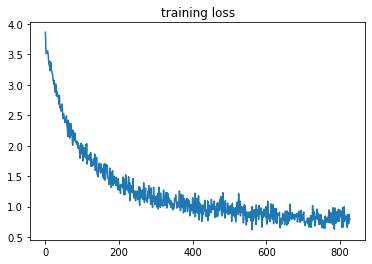

In [ ]:
plt.plot(losses);
plt.title("training loss");

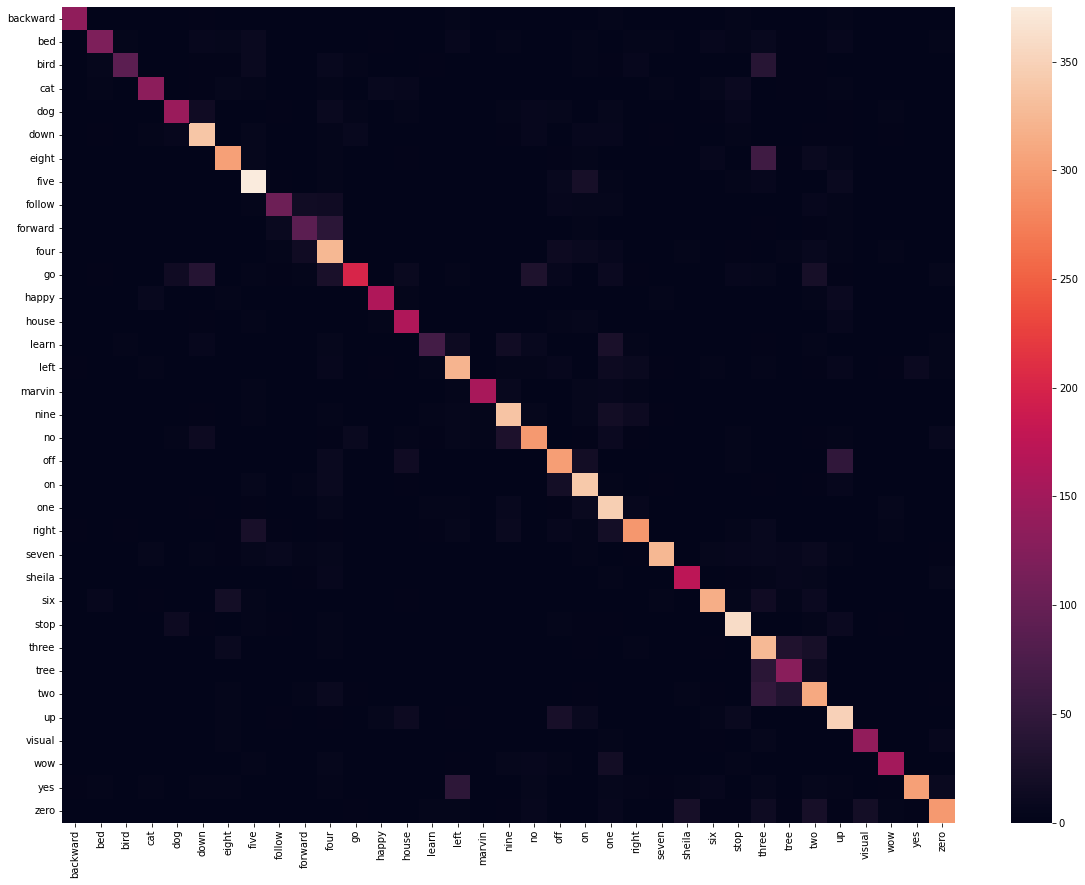

In [ ]:
from torchmetrics import ConfusionMatrix
import pandas as pd
import seaborn as sn

preds, target = test(model, print_log = False)
confmat = ConfusionMatrix(num_classes=len(labels))
result = confmat(preds, target)

df_cm = pd.DataFrame(result.numpy(), 
                     index = labels,
                     columns = labels)
plt.figure(figsize = (20,15))
sn.heatmap(df_cm, annot=False)